In [37]:
import itertools 
import numpy as np
import matplotlib.pyplot as plt
import pickle

# def generate_expansion_configs(config_length, min_expansion, max_expansion):
#     values = [i for i in range(min_expansion, max_expansion)]
#     result = list(itertools.product(values, repeat=config_length))
#     return result

def is_small_and_monotonic_decreasing(arr):
    arr = np.array(arr)
    return np.prod(arr) <= 64 and np.all(arr[:-1] >= arr[1:])


def generate_expansion_configs(): 
    k_1_values = np.array([1, 2, 4, 8, 16, 32]) 
    k_2_values = np.array([1, 2]) 
    remaining_k_i_values = np.array([1]) 
    all_configs = [] 
    for length in [2, 3, 4, 8, 16, 32]:
        all_configs.extend( 
            list( 
                itertools.product( 
                    k_1_values, 
                    k_2_values, 
                    *[remaining_k_i_values for _ in range(length - 2)], 
                ) 
            ) 
        ) 
    return list(filter(is_small_and_monotonic_decreasing, all_configs))

In [38]:
import dataclasses

@dataclasses.dataclass
class BenchmarkResult:
    mean_time: float
    median_time: float
    p90_time: float
    num_samples: int
    mem_gb: float
    utilization: float

In [56]:
# expansion_configs = []
# for length in range(2, 4):
#     expansion_configs.extend(generate_expansion_configs(length, 2, 6))
expansion_configs = generate_expansion_configs()
kv_sizes = [0, 2, 4, 8, 16, 64, 128]

def construct_data_dict(seq_dict, tree_dict, param):
    data_dict = {}
    for config in expansion_configs:
        data_dict[str(config)] = []
        for kv_size in kv_sizes:
            overall_conf = str(config) + ", " + str(kv_size)
            if (overall_conf in seq_dict):
                diff = (seq_dict[overall_conf]).median_time - (tree_dict[overall_conf]).median_time
                if (diff < 0):
                    print(overall_conf)
                if (param == 0):
                    diff = min(diff, 0.010) * 1000 # cap at 0.03 and convert to ms
                elif (param == 2):
                    diff = -diff
                data_dict[str(config)].append(diff)
            else:
                data_dict[str(config)].append(0.0)
    return data_dict

In [57]:
# Custom normalization
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint
        rescaled = (result - vmin) / (vmax - vmin)  # rescale to [0, 1]
        rescaled = np.ma.masked_where(np.isnan(rescaled), rescaled)
        if midpoint is not None:
            midpoint_rescaled = (midpoint - vmin) / (vmax - vmin)
            rescaled = np.where(rescaled < midpoint_rescaled,
                                0.5 * rescaled / midpoint_rescaled,
                                0.5 + 0.5 * (rescaled - midpoint_rescaled) / (1 - midpoint_rescaled))
        if is_scalar:
            rescaled = rescaled[0]
        return rescaled

In [58]:
from matplotlib.colors import TwoSlopeNorm

def construct_graphs(seq_dict, tree_dict, flash):
    # params = {1: "Memory Usage (GB)"}
    params = {0: "Time"}
    for param in params:
        data_dict = construct_data_dict(seq_dict, tree_dict, param)
        
        
        data_keys = list(data_dict.keys())
        data_vals = list(data_dict.values())
        
        
        
        data = np.array(list(data_dict.values())).T
        
        # Create the heat map
        fig, ax = plt.subplots(figsize=(64,24)) 

        # Ensure vmin and vmax are correctly calculated from the data
        vmin = np.min(data)
        vmax = np.max(data)
        midpoint = 0  # Midpoint set to 0 to emphasize negative values
        # print(vmin)
        # print(vmax)
        
        #norm = MidpointNormalize(vmin=np.min(data), vmax=np.max(data), midpoint=0)  # Adjust midpoint as needed
        # norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)
        cax = ax.matshow(data, cmap='coolwarm', vmin=-vmax, vmax=vmax)
        
        # Add a colorbar to show the scale
        colorbar = fig.colorbar(cax)
        
        # Set ticks on the colorbar at smaller intervals
        # num_ticks #3= 30  # Number of ticks you want
        #ticks #= []
        #colorbar.set_ticks(ticks)
        
        # Increase colorbar font size
        # colorbar.ax.tick_params(labelsize=12)
        
        # Set x and y axis ticks and labels
        ax.set_xticks(np.arange(len(data_dict.keys())))
        ax.set_xticklabels(data_dict.keys(), fontsize=12)
        ax.set_yticks(np.arange(len(kv_sizes)))
        ax.set_yticklabels(kv_sizes, fontsize=12)
        
        ax.set_xticks(np.arange(len(data_dict.keys())))

        x_labels = []
        for key in data_dict.keys():
            if len(key.split(",")) <= 8:
                x_labels.append(key)
            else:
                split = key.split(",")
                if '2' in split[1]:
                    new_label = split[0] + ", 2, 1, ..., 1_" + str(len(split) - 1) + ")"
                else:
                    new_label = split[0] + ", 1, ..., 1_" + str(len(split)) + ")"
                x_labels.append(new_label)
        ax.set_xticklabels(x_labels)
        ax.set_yticks(np.arange(len(kv_sizes)))
        ax.set_yticklabels(kv_sizes)
        
        # Add labels and title
        title = 'Measured '+ params[param]+ ' Difference between Sequential Decoding and Tree Decoding'
        if (flash):
            title += ': W/ Flash'
        else:
            title += ': W/O Flash'
        # plt.title(title, fontsize=12)
        plt.xticks(rotation=25)
        plt.xlabel('Tree Configs')
        plt.ylabel('KV-Cache Sizes')
        
        # Display the plot
        # Adjust layout to prevent overlapping
        plt.tight_layout()
        
        # Save the plot as a PNG file
        plt.savefig('heatmap.png', format='png', dpi=300, bbox_inches='tight')
        plt.show()

(1, 1), 0
(1, 1), 4
(1, 1), 8
(1, 1), 16
(1, 1), 64
(1, 1), 128
(2, 1), 16
(2, 1), 128
(2, 2), 0
(2, 2), 4
(2, 2), 8
(2, 2), 16
(2, 2), 64
(2, 2), 128
(4, 1), 0
(4, 1), 4
(4, 1), 8
(4, 1), 16
(4, 1), 64
(4, 1), 128
(4, 2), 0
(4, 2), 4
(4, 2), 8
(4, 2), 64
(4, 2), 128
(8, 1), 0
(8, 1), 4
(8, 1), 8
(8, 1), 16
(8, 1), 64
(8, 1), 128
(8, 2), 0
(8, 2), 4
(8, 2), 8
(8, 2), 16
(16, 1), 0
(16, 1), 4
(16, 1), 8
(16, 1), 16
(32, 1), 4
(1, 1, 1), 0
(1, 1, 1), 4
(1, 1, 1), 8
(1, 1, 1), 16
(1, 1, 1), 64
(1, 1, 1), 128
(2, 1, 1), 0
(2, 1, 1), 4
(2, 1, 1), 8
(2, 1, 1), 16
(2, 1, 1), 64
(2, 2, 1), 4
(2, 2, 1), 8
(2, 2, 1), 16
(2, 2, 1), 64
(2, 2, 1), 128
(4, 1, 1), 4
(4, 1, 1), 8
(4, 1, 1), 64
(4, 1, 1), 128
(4, 2, 1), 0
(4, 2, 1), 4
(4, 2, 1), 8
(8, 1, 1), 0
(8, 1, 1), 4
(8, 1, 1), 8
(8, 1, 1), 16
(16, 1, 1), 4
(32, 1, 1), 4
(1, 1, 1, 1), 0
(1, 1, 1, 1), 4
(1, 1, 1, 1), 8
(1, 1, 1, 1), 16
(1, 1, 1, 1), 64
(1, 1, 1, 1), 128
(2, 1, 1, 1), 0
(2, 1, 1, 1), 8
(2, 1, 1, 1), 16
(2, 1, 1, 1), 64
(2, 1, 1, 1)

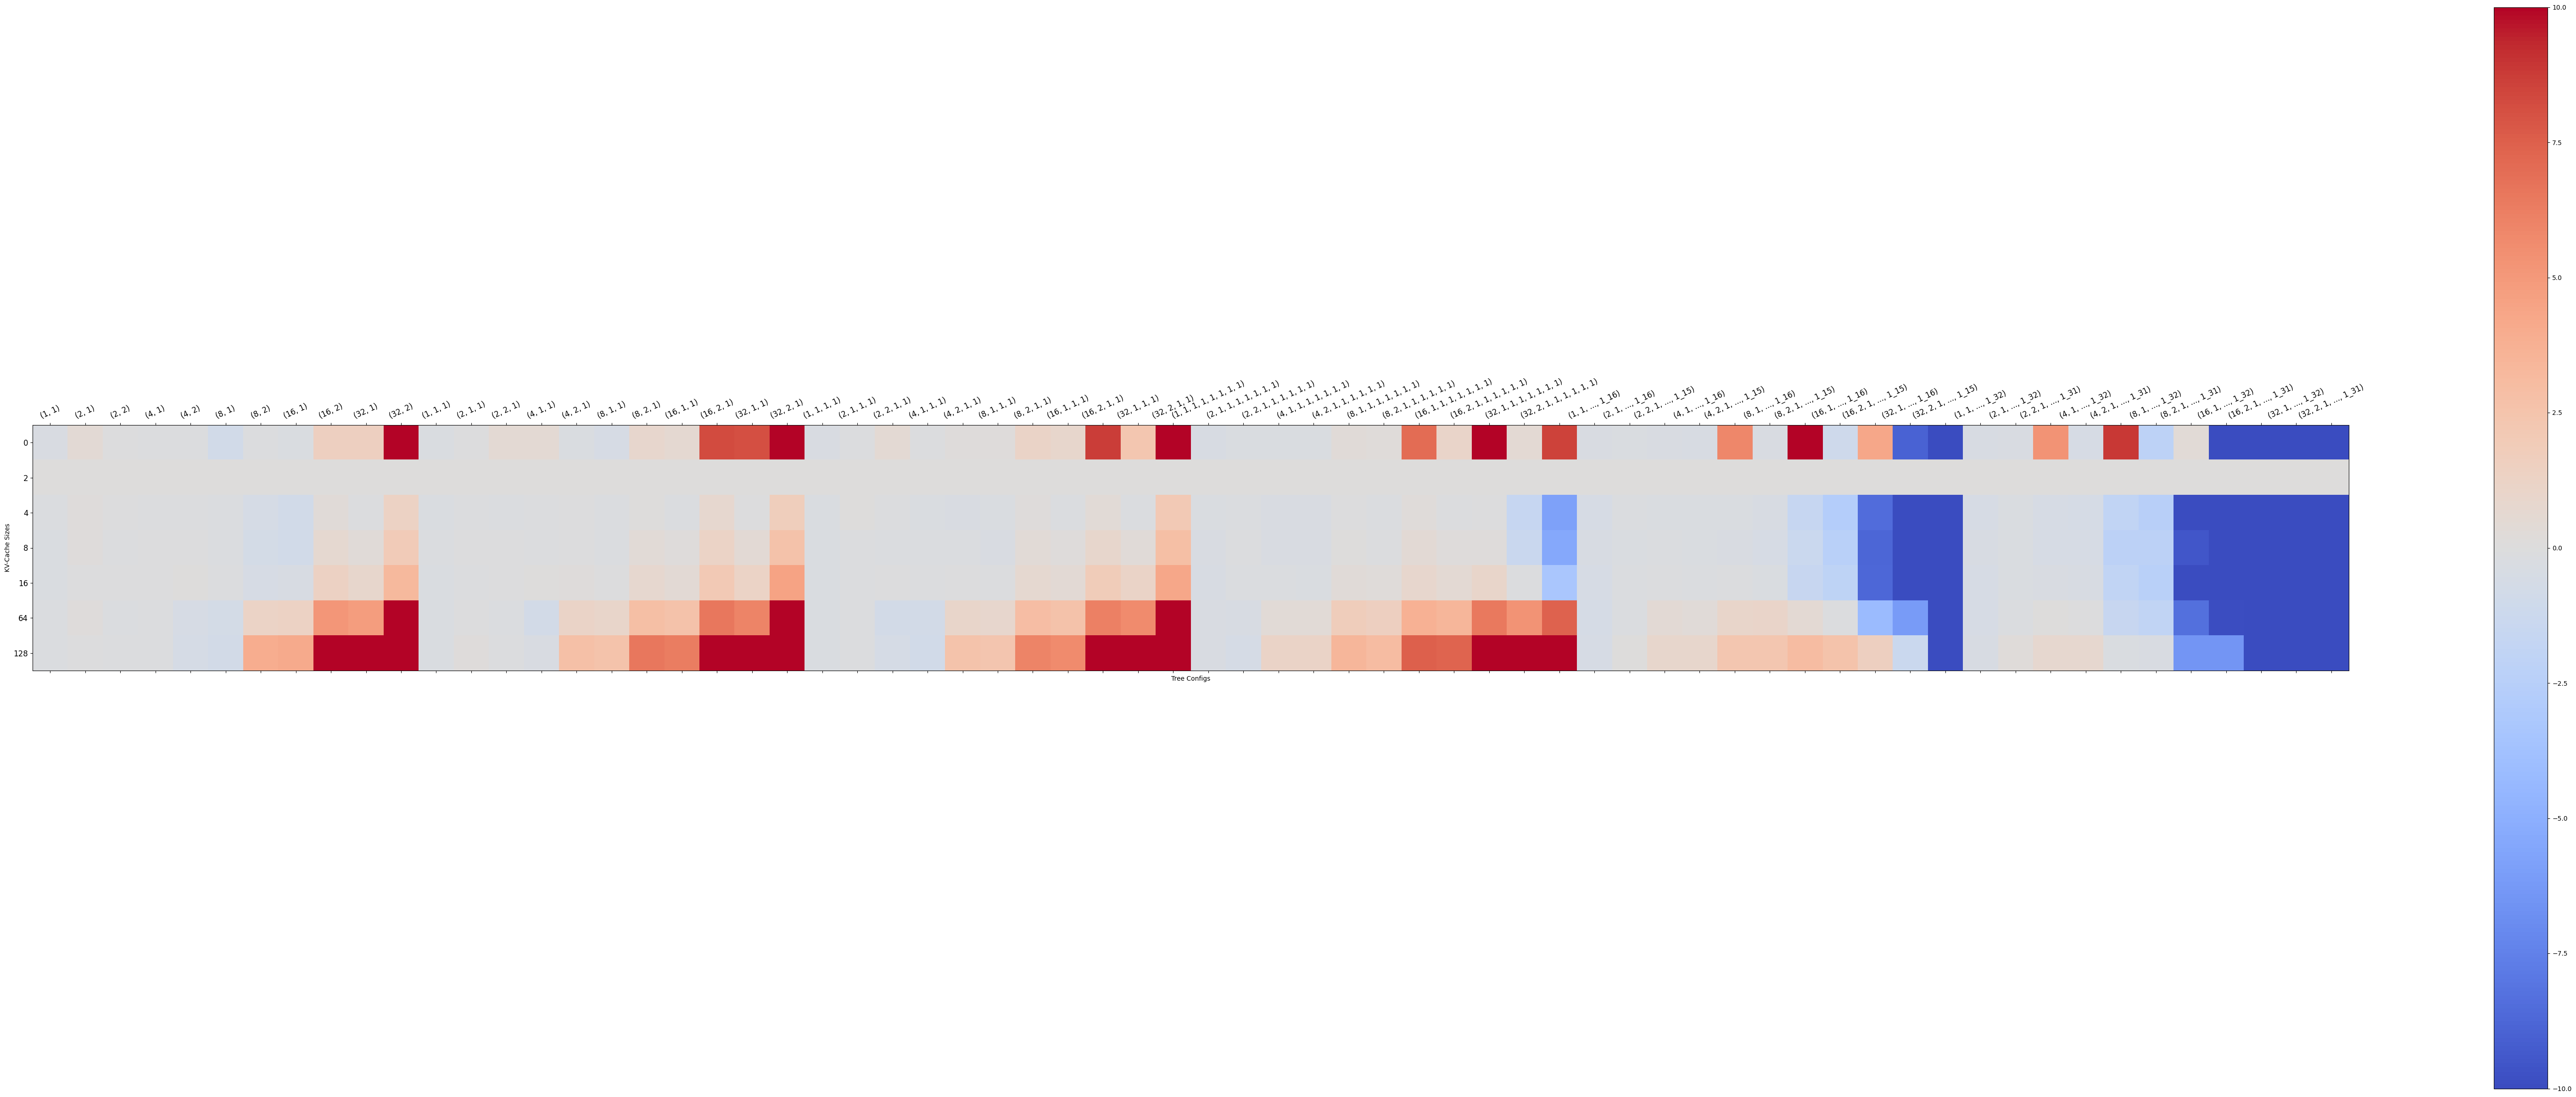

In [59]:
# FLASH GRAPHS
seq_flash = open("saved_sequential_2024-06-09_23:55:55.pkl",'rb')
tree_flash = open("saved_tree_2024-06-09_23:55:55.pkl", 'rb')
seq = pickle.load(seq_flash)
tree = pickle.load(tree_flash)

construct_graphs(seq, tree, True)

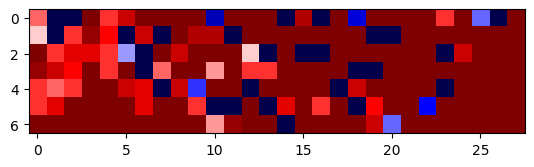

In [135]:
# NO FLASH GRAPHS
seq_no_flash = open("sequential_a6000_no_flash.pkl",'rb')
tree_no_flash = open("tree_a6000_no_flash.pkl", 'rb')
seq = pickle.load(seq_no_flash)
tree = pickle.load(tree_no_flash)

data_dict = construct_data_dict(seq, tree, 0)
np.array(list(data_dict.values())).T
plt.imshow(data, cmap='seismic', interpolation='nearest', vmin=-10, vmax=10)
#construct_graphs(seq, tree, False)